# Итоговый проект первого года обучения <br /> (курс "Профессия Data Science")
## Тема: Агентство недвижимости

**Что необходимо сделать:** разработать сервис для предсказания стоимости домов на основе истории предложений.

## Base Line
#### Первичная очистка и кодорование данных, получение базовой модели, относительно которолй будет оцениваться качество улучшения предсказаний

In [2]:
import numpy as np
import pandas as pd
import json
import pickle
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('default')

In [4]:
import sys, os
sys.path.append(os.path.join(os.path.abspath(''), '..', 'shared_libs'))
import data_transform

Загрузка предварительно очищенного от выбросов целевого показателя осовной набор данных.

In [5]:
df = pd.read_csv('data/data_target_cleared.csv')
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,for sale,NaN,multi-family,803 Passmore St,2 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",yes,Philadelphia,"[{'rating': ['3/10', '2/10', '3/10'], 'data': ...","1,350 sqft",19111,3 Beds,PA,2.0,NaN,NaN,PAPH853202,195000.0
1,for sale,NaN,lot/land,3609 Summit Ave,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Greensboro,"[{'rating': ['5/10', '5/10', '4/10'], 'data': ...",NaN,27405,NaN,NC,NaN,NaN,NaN,930640,199000.0
2,Active,NaN,Land,4011 Valley Vista Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Lowell,"[{'rating': ['7', '6'], 'data': {'Distance': [...",0,49331,NaN,MI,NaN,NaN,NaN,19058608,189900.0
3,For sale,NaN,Single Family,118 S 17th St,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '1909', 'fac...",NaN,Allentown,"[{'rating': ['2/10', '2/10', '2/10'], 'data': ...","Total interior livable area: 1,617 sqft",18104,3 bd,PA,2.0,628531,NaN,NaN,189000.0
4,for sale,NaN,single-family home,6820 Quincy St,4 Baths,"{'atAGlanceFacts': [{'factValue': '1925', 'fac...",yes,Philadelphia,"[{'rating': ['3/10', '1/10'], 'data': {'Distan...","5,013 sqft",19119,6 Beds,PA,3.0,NaN,NaN,PAPH851112,579000.0


Проверка на наличие пропусков в данных (в процентах)

In [6]:
np.round(df.isna().sum() / df.shape[0] * 100, 4)

status          10.7686
private pool    98.8581
propertyType     8.8121
street           0.0006
baths           26.4719
homeFacts        0.0000
fireplace       71.9139
city             0.0068
schools          0.0000
sqft             9.2487
zipcode          0.0000
beds            22.3483
state            0.0000
stories         38.1452
mls-id          93.1189
PrivatePool     89.2497
MlsId           17.5125
target           0.0000
dtype: float64

In [7]:
np.round(df['status'].value_counts() / df.shape[0] * 100, 4)[:20]

for sale                     41.8060
Active                       27.5169
For sale                     11.9042
New construction              1.5092
foreclosure                   1.2923
Pending                       1.2241
Pre-foreclosure               0.5560
P                             0.4155
Pre-foreclosure / auction     0.3560
Under Contract Show           0.3264
 / auction                    0.2225
Under Contract   Showing      0.2211
Active Under Contract         0.2005
Under Contract                0.1941
New                           0.1918
Contingent                    0.1586
Price Change                  0.1569
Auction                       0.1352
A Active                      0.1107
Foreclosure                   0.0820
Name: status, dtype: float64

После анализа наиболее часто встречающихся значений в поле *status*, становится понятно, что поле не информативно (около 79% всех значений - **For sale** или **Active**, что по смыслу одно и тоже)

Удаление неинформативных признаков и признаков, в которых слишком большое число пропусков

In [8]:
df = data_transform.drop_not_informative_columns(df, ['status', 'private pool', 'fireplace', 'mls-id', 'PrivatePool'])
df.head()

,propertyType,street,baths,homeFacts,city,schools,sqft,zipcode,beds,state,stories,MlsId,target
0,multi-family,803 Passmore St,2 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",Philadelphia,"[{'rating': ['3/10', '2/10', '3/10'], 'data': ...","1,350 sqft",19111,3 Beds,PA,2.0,PAPH853202,195000.0
1,lot/land,3609 Summit Ave,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",Greensboro,"[{'rating': ['5/10', '5/10', '4/10'], 'data': ...",NaN,27405,NaN,NC,NaN,930640,199000.0
2,Land,4011 Valley Vista Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",Lowell,"[{'rating': ['7', '6'], 'data': {'Distance': [...",0,49331,NaN,MI,NaN,19058608,189900.0
3,Single Family,118 S 17th St,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '1909', 'fac...",Allentown,"[{'rating': ['2/10', '2/10', '2/10'], 'data': ...","Total interior livable area: 1,617 sqft",18104,3 bd,PA,2.0,NaN,189000.0
4,single-family home,6820 Quincy St,4 Baths,"{'atAGlanceFacts': [{'factValue': '1925', 'fac...",Philadelphia,"[{'rating': ['3/10', '1/10'], 'data': {'Distan...","5,013 sqft",19119,6 Beds,PA,3.0,PAPH851112,579000.0


Количество пропусков в данных среди оставшихся признаков (в процентах)

In [9]:
np.round(df.isna().sum() / df.shape[0] * 100, 4)

propertyType     8.8121
street           0.0006
baths           26.4719
homeFacts        0.0000
city             0.0068
schools          0.0000
sqft             9.2487
zipcode          0.0000
beds            22.3483
state            0.0000
stories         38.1452
MlsId           17.5125
target           0.0000
dtype: float64

In [10]:
all_facts_labels = {}
print_count = 0

def collect_facts_labels(value):
    global all_facts_labels
    global print_count
    
    try:
        src_value = value
        value = data_transform.convert_to_json_str(value)
        facts = json.loads(value)['atAGlanceFacts']
        for fact in facts:
            all_facts_labels[fact['factLabel']] = 1
    except:
        print_count += 1
        if print_count <= 25:
            print(src_value)
  
df['homeFacts'].apply(collect_facts_labels)

set(all_facts_labels)

{'Cooling',
 'Heating',
 'Parking',
 'Price/sqft',
 'Remodeled year',
 'Year built',
 'lotsize'}

Декодирование и формирование отдельных признаков из поля *homeFacts*

В результате получаем следующие признаки:
* *fact_year_built* - год постройки
* *fact_remodeled_year* - год реконструкции
* *fact_cooling* - данные по системе вентиляции
* *fact_heating* - данные по системе отопления
* *fact_parking* - данные о наличии парковки

In [11]:
facts = [
    {'col_name': 'fact_year_built', 'col_value': 'Year built'},
    {'col_name': 'fact_remodeled_year', 'col_value': 'Remodeled year'},
    {'col_name': 'fact_cooling', 'col_value': 'Cooling'},
    {'col_name': 'fact_heating', 'col_value': 'Heating'},
    {'col_name': 'fact_parking', 'col_value': 'Parking'}
]

for fact in facts:
    df[fact['col_name']] = df['homeFacts'].apply(lambda x: data_transform.get_subfact(x, fact['col_value']))
    
df = df.drop('homeFacts', axis=1)
    
df.head()

,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,fact_year_built,fact_remodeled_year,fact_cooling,fact_heating,fact_parking
0,multi-family,803 Passmore St,2 Baths,Philadelphia,"[{'rating': ['3/10', '2/10', '3/10'], 'data': ...","1,350 sqft",19111,3 Beds,PA,2.0,PAPH853202,195000.0,1950,NaN,Central,Other,NaN
1,lot/land,3609 Summit Ave,NaN,Greensboro,"[{'rating': ['5/10', '5/10', '4/10'], 'data': ...",NaN,27405,NaN,NC,NaN,930640,199000.0,NaN,NaN,NaN,NaN,NaN
2,Land,4011 Valley Vista Dr,NaN,Lowell,"[{'rating': ['7', '6'], 'data': {'Distance': [...",0,49331,NaN,MI,NaN,19058608,189900.0,NaN,NaN,NaN,NaN,NaN
3,Single Family,118 S 17th St,Bathrooms: 2,Allentown,"[{'rating': ['2/10', '2/10', '2/10'], 'data': ...","Total interior livable area: 1,617 sqft",18104,3 bd,PA,2.0,NaN,189000.0,1909,NaN,NaN,Baseboard,1 space
4,single-family home,6820 Quincy St,4 Baths,Philadelphia,"[{'rating': ['3/10', '1/10'], 'data': {'Distan...","5,013 sqft",19119,6 Beds,PA,3.0,PAPH851112,579000.0,1925,NaN,NaN,NaN,Detached Garage


In [12]:
df.isna().sum() / df.shape[0] * 100

propertyType            8.812139
street                  0.000563
baths                  26.471905
city                    0.006760
schools                 0.000000
sqft                    9.248718
zipcode                 0.000000
beds                   22.348345
state                   0.000000
stories                38.145187
MlsId                  17.512457
target                  0.000000
fact_year_built        14.365707
fact_remodeled_year    58.662716
fact_cooling           30.579693
fact_heating           27.247608
fact_parking           45.056375
dtype: float64

Декодирование и формирование отдельных признаков из поля *schools*

В результате получаем следующие признаки:
* *schools_count* - количество близлежащих школ
* *schools_avg_rate* - средний рейтинг школ
* *schools_min_distance* - минимальное расстояние до школы
* *schools_avg_distance* - среднее расстояние до школ
* *schools_PK* - наличие рядом школы типа PK (ясли)
* *schools_K* - наличие рядом школы типа K (детский сад)
* *schools_M* - наличие рядом школы типа M (начальная школа)
* *schools_H* - наличие рядом школы типа H (высшая школа)

In [13]:
df['schools_count'] = df['schools'].apply(lambda x: data_transform.get_schools_count(x))
df['schools_avg_rate'] = df['schools'].apply(lambda x: data_transform.get_schools_avg_rate(x))
df['schools_min_distance'] = df['schools'].apply(lambda x: data_transform.get_schools_min_distance(x))
df['schools_avg_distance'] = df['schools'].apply(lambda x: data_transform.get_schools_avg_distance(x))
df['schools_grades_list'] = df['schools'].apply(lambda x: data_transform.get_schools_grades_list(x))

df['schools_PK'] = df['schools_grades_list'].apply(lambda x: 1 if 'PK' in x else 0)
df['schools_K'] = df['schools_grades_list'].apply(lambda x: 1 if 'K' in x else 0)
df['schools_M'] = df['schools_grades_list'].apply(lambda x: 1 if 'M' in x else 0)
df['schools_H'] = df['schools_grades_list'].apply(lambda x: 1 if 'H' in x else 0)

df = df.drop(['schools_grades_list', 'schools'], axis=1)

In [14]:
df.head()

,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,MlsId,...,fact_heating,fact_parking,schools_count,schools_avg_rate,schools_min_distance,schools_avg_distance,schools_PK,schools_K,schools_M,schools_H
0,multi-family,803 Passmore St,2 Baths,Philadelphia,"1,350 sqft",19111,3 Beds,PA,2.0,PAPH853202,...,Other,NaN,3,2.666667,0.65,0.966667,0,1,1,1
1,lot/land,3609 Summit Ave,NaN,Greensboro,NaN,27405,NaN,NC,NaN,930640,...,NaN,NaN,3,4.666667,0.66,6.053333,1,1,1,1
2,Land,4011 Valley Vista Dr,NaN,Lowell,0,49331,NaN,MI,NaN,19058608,...,NaN,NaN,2,6.500000,4.60,4.700000,0,1,1,1
3,Single Family,118 S 17th St,Bathrooms: 2,Allentown,"Total interior livable area: 1,617 sqft",18104,3 bd,PA,2.0,NaN,...,Baseboard,1 space,3,2.000000,0.10,0.233333,0,1,1,1
4,single-family home,6820 Quincy St,4 Baths,Philadelphia,"5,013 sqft",19119,6 Beds,PA,3.0,PAPH851112,...,NaN,Detached Garage,2,2.000000,0.44,1.200000,0,1,1,1


In [15]:
df.isna().sum() / df.shape[0] * 100

propertyType             8.812139
street                   0.000563
baths                   26.471905
city                     0.006760
sqft                     9.248718
zipcode                  0.000000
beds                    22.348345
state                    0.000000
stories                 38.145187
MlsId                   17.512457
target                   0.000000
fact_year_built         14.365707
fact_remodeled_year     58.662716
fact_cooling            30.579693
fact_heating            27.247608
fact_parking            45.056375
schools_count            0.000000
schools_avg_rate         0.000000
schools_min_distance     0.000000
schools_avg_distance     0.000000
schools_PK               0.000000
schools_K                0.000000
schools_M                0.000000
schools_H                0.000000
dtype: float64

Формируем выборку почтовых индексов и названий штатов для записей с отсутствующим название города.

In [16]:
df[df['city'].isna()][['zipcode', 'state']]

,zipcode,state
20848,78045,TX
22165,78045,TX
23697,38732,MS
48347,32668,FL
50667,78045,TX
63162,34747,FL
102797,33126,FL
148498,32686,FL
151840,34432,FL
159588,34747,FL


По эти данным восстанавливаем название города.

In [17]:
city_by_zip_state = {
    '32686_FL': 'Reddick',
    '32668_FL': 'Morriston',
    '78045_TX': 'Laredo',
    '34474_FL': 'Ocala',
    '34432_FL': 'Dunnellon',
    '34741_FL': 'Kissimmee',
    '38732_MS': 'Cleveland',
    '34747_FL': 'Kissimmee',
    '34744_FL': 'Kissimmee',
    '33126_FL': 'Miami',
    '77032_TX': 'Houston'
}

In [18]:
def found_city_by_zip_state(zipcode, state):
    key = zipcode+'_'+state
    return np.NaN if key not in city_by_zip_state else city_by_zip_state[key]

In [19]:
city_mask = df['city'].isna()
df.loc[city_mask, 'city'] = df[city_mask].apply(lambda x: found_city_by_zip_state(x['zipcode'], x['state']), axis=1)

In [20]:
df = df.dropna(subset=['city'], axis=0)

In [21]:
df = df.dropna(subset=['street'], axis=0)

Анализ распределения значений в поле *sqft*

В качесьве первого шага конвертируем данные в тип *float* для дальнейшего анализа и использования.

In [22]:
mask = ~df['sqft'].isna()
df.loc[mask, 'sqft_fl'] = df[mask]['sqft'].apply(lambda x: data_transform.convert_sqft_str_to_float(x))

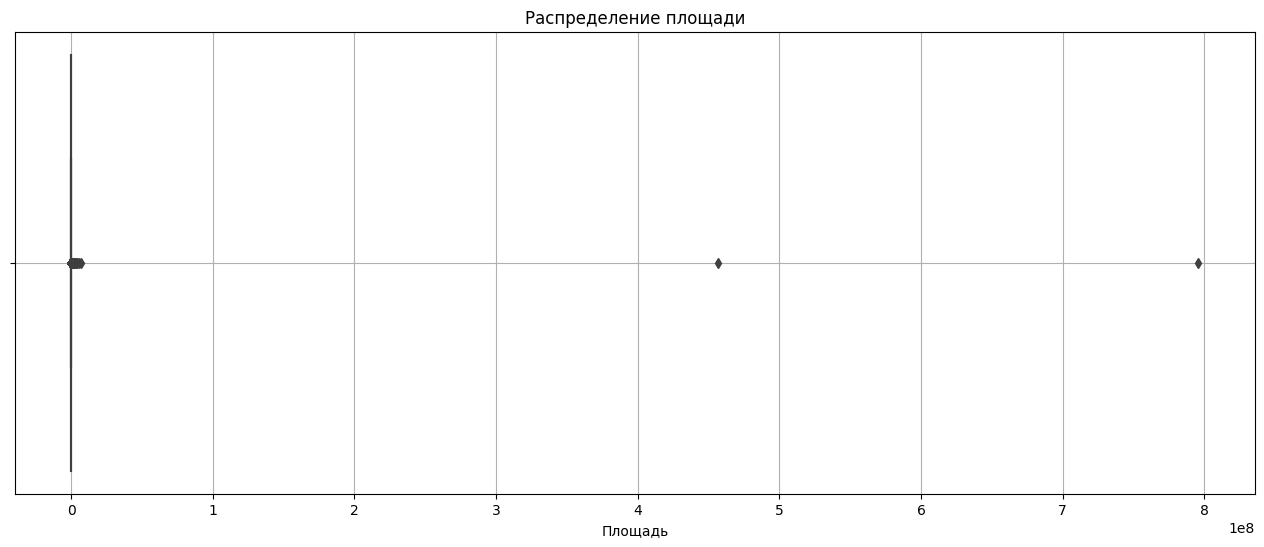

In [23]:
fig = plt.figure(figsize=(16, 6))
boxplot = sns.boxplot(
    data=df,
    x='sqft_fl',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение площади');
boxplot.set_xlabel('Площадь');
boxplot.grid()

Из диаграмы заметно наличие выбросов "сверху"

In [26]:
df[(df['sqft_fl'] < 15000)].shape[0] / df[~df['sqft_fl'].isna()].shape[0] * 100

99.50539246641179

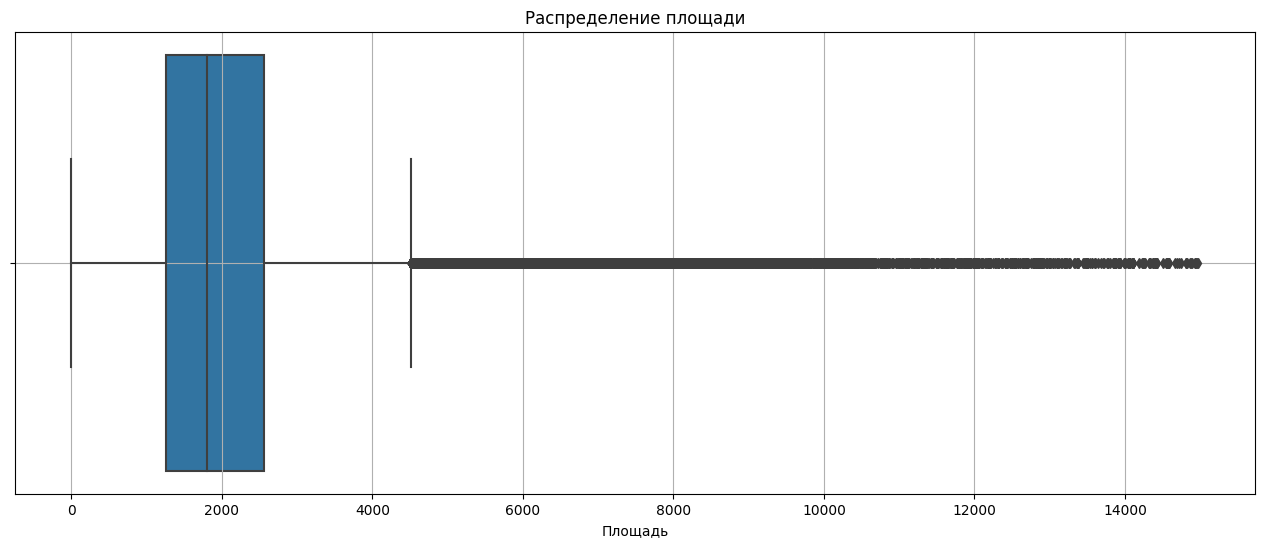

In [27]:
fig = plt.figure(figsize=(16, 6))
boxplot = sns.boxplot(
    data=df[df['sqft_fl'] < 15000],
    x='sqft_fl',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение площади');
boxplot.set_xlabel('Площадь');
boxplot.grid()

В качестве верхней границы отсечения "нормальных" данных от выбросов принимаем значение 15000.

В данный диапазон попадает 99.5% всех данных, остальные считаем выбросами, и записи с такими значения отбрасываем.

In [29]:
df = df[df['sqft_fl'] < 15000]
df = df.drop('sqft', axis=1)

sqft_fill_value = df['sqft_fl'].median()
df['sqft_fl'].fillna(sqft_fill_value, inplace=True)

Пропущенные значение заполняем медианным значением площади.

In [30]:
pr_type_fiil_value = df['propertyType'].mode()[0]
df['propertyType'].fillna(pr_type_fiil_value, inplace=True)

Пропущенные значения в поле *propertyType* заполняем модой.

In [31]:
df['has_mls_id'] = 0
mask = ~df['MlsId'].isna()
df.loc[mask, 'has_mls_id'] = 1

df = df.drop('MlsId', axis=1)

Вместо поля *MlsId* (которое имеет достаточно большое количество пропусков и его достаточно сложно использовать в качестве информативного) добаяляем поле *has_mls_id* (наличие/отсутствие данного параметра в данных).

In [32]:
(df['propertyType'].value_counts() / df.shape[0] * 100).head(10)

single-family home               33.828373
Single Family                    17.109835
Single Family Home                8.844783
condo                             7.102478
Condo                             4.539950
lot/land                          4.423382
townhouse                         3.169421
Condo/Townhome/Row Home/Co-Op     2.155387
multi-family                      2.110118
Land                              2.018730
Name: propertyType, dtype: float64

In [33]:
pr_type_features = data_transform.get_pr_type_features_list()

mask = ~df['propertyType'].isna()

for pr_type_feature in pr_type_features:
    df[pr_type_feature] = 0
    df.loc[mask, pr_type_feature] = df[mask]['propertyType'].apply(lambda x: data_transform.get_pr_type_feature(x, pr_type_feature))

На основании анализа наиболее часто встречающихся значений в поле *propertyType* выделяем следующие бинарные признаки (по совпадением с группой регулярных выражений):

* SINGLE-FAMILY
* MULTI-FAMILY
* CONDOMINIMUM
* LAND
* TOWNHOUSE
* TRADITIONAL
* MODERN
* RANCH
* DETACHED

И создаем группу соответсвующих признаков вместо исходного поля *propertyType*

In [34]:
story_features = data_transform.get_stories_features_list()

mask = ~df['propertyType'].isna()

for story_feature in story_features:
    df[story_feature] = 0
    df.loc[mask, story_feature] = df[mask]['propertyType'].apply(lambda x: data_transform.get_stroty_feature_by_pr_type(x, story_feature))

Помимо этого из поля *propertyType* имеется возможность выделить информацио об этажности объекта в виде группы банарных признаков:

* 1-STORY
* 2-STORY
* 3-STORY
* OTHER-STORY

In [35]:
(df['stories'].value_counts() / df.shape[0] * 100).head(10)

1.0    18.470179
2.0    15.154482
1       6.350441
2       4.973970
3.0     3.062755
0.0     1.974027
One     1.620077
0       1.165686
3       1.149276
9.0     0.805512
Name: stories, dtype: float64

In [36]:
mask = ~df['stories'].isna()
df.loc[mask, 'stories_int'] = df[mask]['stories'].apply(data_transform.get_story_count_by_story)

In [37]:
story_features = data_transform.get_stories_features_list()
st_count = 1

mask = ~df['stories_int'].isna()
for st_feature in story_features:
    if st_count < len(story_features):
        df.loc[mask, st_feature] = df[mask]['stories_int'].apply(lambda x: 1 if st_count == x else 0)
    else:
        df.loc[mask, st_feature] = df[mask]['stories_int'].apply(lambda x: 1 if st_count <= x else 0)

    st_count += 1

Группа бинарных признаков об этажности дополняется (там где это возможно) на основании сконвертированного в *int* поля *stories*

In [38]:
df = df.drop(['propertyType', 'stories', 'stories_int'], axis=1)

In [39]:
na_cols_list = np.round(df.isna().sum() / df.shape[0] * 100, 2)
mask = na_cols_list > 0
na_cols_list[mask]

baths                  26.26
beds                   22.17
fact_year_built        14.31
fact_remodeled_year    58.50
fact_cooling           30.35
fact_heating           27.04
fact_parking           44.91
dtype: float64

In [40]:
mask = ~df['beds'].isna()
df.loc[mask, 'beds'] = df[mask]['beds'].apply(data_transform.clear_beds_from_sqr)

In [41]:
mask = ~df['beds'].isna()
df.loc[mask, 'beds_int'] = df[mask]['beds'].apply(data_transform.convert_beds_str_to_int)

In [42]:
df['beds_int'].value_counts() / df.shape[0] * 100

3.0     29.050192
4.0     18.969556
2.0     13.664271
5.0      5.834088
1.0      1.703825
6.0      1.652048
7.0      0.424117
0.0      0.376019
8.0      0.302173
9.0      0.120813
10.0     0.070733
12.0     0.049230
11.0     0.031689
16.0     0.017825
13.0     0.011600
14.0     0.011034
15.0     0.009054
18.0     0.007922
64.0     0.007073
24.0     0.006507
20.0     0.003112
17.0     0.002829
22.0     0.001981
32.0     0.001698
19.0     0.001698
26.0     0.001698
34.0     0.000849
28.0     0.000849
30.0     0.000849
23.0     0.000566
25.0     0.000566
27.0     0.000566
40.0     0.000566
21.0     0.000283
46.0     0.000283
36.0     0.000283
44.0     0.000283
29.0     0.000283
47.0     0.000283
42.0     0.000283
Name: beds_int, dtype: float64

In [43]:
beds_features = data_transform.get_beds_features_list()
beds_count = 1

mask = ~df['beds_int'].isna()
for bed_feature in beds_features:
    df[bed_feature] = 0
    if beds_count < len(beds_features):
        df.loc[mask, bed_feature] = df[mask]['beds_int'].apply(lambda x: 1 if beds_count == x else 0)
    else:
        df.loc[mask, bed_feature] = df[mask]['beds_int'].apply(lambda x: 1 if beds_count <= x else 0)

    beds_count += 1

Аналогично формируются бинарные признаки о числе спален на основании поля *beds*:

* 1-BEDROOM
* 2-BEDROOMS
* 3-BEDROOMS
* 4-BEDROOMS
* 5-BEDROOMS
* 6-BEDROOMS
* OTHER-BEDROOMS

In [44]:
df = df.drop(['beds_int', 'beds'], axis=1)

In [45]:
na_cols_list = np.round(df.isna().sum() / df.shape[0] * 100, 2)
mask = na_cols_list > 0
na_cols_list[mask]

baths                  26.26
fact_year_built        14.31
fact_remodeled_year    58.50
fact_cooling           30.35
fact_heating           27.04
fact_parking           44.91
dtype: float64

In [46]:
(df['baths'].value_counts() / df.shape[0] * 100)

2 Baths       14.412913
3 Baths        9.887958
2              5.726007
2.0            4.589181
4 Baths        4.049344
                ...    
10.5 Baths     0.000283
5.2 Baths      0.000283
26 Baths       0.000283
22             0.000283
19 Baths       0.000283
Name: baths, Length: 187, dtype: float64

In [47]:
mask = ~df['baths'].isna()
df.loc[mask, 'baths_int'] = df[mask]['baths'].apply(data_transform.convert_baths_str_to_int)

In [48]:
df['baths_int'].value_counts() / df.shape[0] * 100

2.0       32.256111
3.0       18.145654
4.0        9.026992
1.0        4.460729
5.0        2.453882
6.0        1.219443
1500.0     0.616795
0.0        0.533330
2000.0     0.500226
1750.0     0.478723
7.0        0.473065
3000.0     0.468538
2250.0     0.396956
1000.0     0.350555
1250.0     0.337257
2750.0     0.269070
2500.0     0.250113
8.0        0.245303
3500.0     0.180229
9.0        0.084314
4000.0     0.080636
750.0      0.065075
5000.0     0.064509
10.0       0.044703
11.0       0.025181
12.0       0.022635
16.0       0.011600
13.0       0.010186
18.0       0.007073
14.0       0.005942
15.0       0.003678
20.0       0.003112
24.0       0.002829
30.0       0.001698
17.0       0.001132
22.0       0.000849
21.0       0.000566
19.0       0.000566
40.0       0.000283
41.0       0.000283
26.0       0.000283
241.0      0.000283
29.0       0.000283
36.0       0.000283
23.0       0.000283
25.0       0.000283
Name: baths_int, dtype: float64

In [49]:
baths_features = data_transform.get_bathrooms_features_list()
baths_count = 1

mask = ~df['baths_int'].isna()
for bath_feature in baths_features:
    df[bath_feature] = 0
    if baths_count < len(baths_features):
        df.loc[mask, bath_feature] = df[mask]['baths_int'].apply(lambda x: 1 if baths_count == x else 0)
    else:
        df.loc[mask, bath_feature] = df[mask]['baths_int'].apply(lambda x: 1 if baths_count <= x else 0)

    baths_count += 1

И формирем бинарные признаки о числе ванных комнат на основании поля *baths*:

* 1-BATHROOM
* 2-BATHROOMS
* 3-BATHROOMS
* 4-BATHROOMS
* 5-BATHROOMS
* 6-BATHROOMS
* OTHER-BATHROOMS

In [50]:
df = df.drop(['baths_int', 'baths'], axis=1)

In [51]:
df['was_remodeled'] = 0

mask = ~df['fact_remodeled_year'].isna()
df.loc[mask, 'was_remodeled'] = df[mask]['fact_remodeled_year'].apply(lambda x: 1)

In [52]:
df = df.drop('fact_remodeled_year', axis=1)

На основании данных о годе реконструкции *fact_remodeled_year* формируем бинарный признак *was_remodeled* (была или нет реконструкция)

In [53]:
na_cols_list = np.round(df.isna().sum() / df.shape[0] * 100, 2)
mask = na_cols_list > 0
na_cols_list[mask]

fact_year_built    14.31
fact_cooling       30.35
fact_heating       27.04
fact_parking       44.91
dtype: float64

In [54]:
years_subset_size = data_transform.get_nunuques_size(df, 'fact_year_built', percent=50, start_n=10, step=5)
subset = data_transform.get_weighted_nuniques_list(df, 'fact_year_built', years_subset_size)

df['fact_year_built'] = df['fact_year_built'].apply(lambda x: data_transform.get_weighted_random_item(subset) if pd.isnull(x) else x)

In [55]:
mask = df['fact_year_built'] == 'No Data'
df.loc[mask, 'fact_year_built'] = df[mask]['fact_year_built'].apply(lambda x: data_transform.get_weighted_random_item(subset))

In [56]:
df['fact_year_built'] = df['fact_year_built'].apply(lambda x: int(x))

Отсутствующие данные о годе постройки заполняем случайным образом, но сохранением распределения среди остальных данных.

Функция *data_transform.get_weighted_nuniques_list* генерирует список позволяющий в дальнейшем генерировть случайный год с распределением, совпадающим с исходными данными (за генерацию случайного года с заданым распределеним отвечает *data_transform.get_weighted_random_item*).

In [57]:
base_year = 2023
df['object_age'] = df['fact_year_built'].apply(lambda x: 0 if (base_year-x) < 0 else (base_year-x))

In [58]:
df = df.drop('fact_year_built', axis=1)

Всесто года постройки создаем признак *object_age* (возраст объекта относительно 2023 года)

In [59]:
(df['fact_cooling'].value_counts() / df.shape[0] * 100)[:50]

Central                                                        43.566376
Central Air                                                     4.042836
No Data                                                         2.851969
Has Cooling                                                     2.675136
None                                                            1.989588
Central Electric                                                1.729289
Wall                                                            1.107684
Central Gas                                                     1.005263
Central Heating                                                 0.790799
Cooling System                                                  0.754866
Central A/C                                                     0.559925
Other                                                           0.484665
Central A/C (Electric), Central Heat (Gas)                      0.458918
Central A/C (Electric), Central Heat (Electric)    

In [60]:
cooling_features = data_transform.get_cooling_features_list()

mask = ~df['fact_cooling'].isna()

for cooling_feature in cooling_features:
    df[cooling_feature] = 0
    df.loc[mask, cooling_feature] = df[mask]['fact_cooling'].apply(lambda x: data_transform.get_cooling_feature(x, cooling_feature))

In [61]:
df = df.drop('fact_cooling', axis=1)

На основании поля *fact_cooling* формируем группу бинарных признаков, описывающих систему кондиционирования:

* CENTRAL_COOLING
* COOLING
* HEATING
* GAS
* ELECTRIC
* ZONED
* HEAT_PUMP
* WALL

In [62]:
(df['fact_heating'].value_counts() / df.shape[0] * 100)[:50]

Forced Air                               22.509054
Forced air                               14.096593
Other                                     7.987211
Electric                                  2.554889
Gas                                       2.506790
No Data                                   2.293742
Central Air                               2.147182
Central Electric                          1.996661
Central                                   1.755885
Heat Pump                                 1.698732
Central, Electric                         1.191999
Baseboard                                 1.046854
Wall                                      0.909631
Electric Heat                             0.863513
Heat pump                                 0.762506
Heating System                            0.756847
Forced air, Heat pump                     0.482684
Radiant                                   0.402614
Central Air, Ceiling Fan(s)               0.396390
Natural Gas Heat               

In [63]:
heating_features = data_transform.get_heating_features_list()

mask = ~df['fact_heating'].isna()

for heat_feature in heating_features:
    df[heat_feature] = 0
    df.loc[mask, heat_feature] = df[mask]['fact_heating'].apply(lambda x: data_transform.get_heating_feature(x, heat_feature))

In [64]:
df = df.drop('fact_heating', axis=1)

На основании поля *fact_heating* формируем группу бинарных признаков, описывающих систему отопления:

* FORCED_AIR_HEAT
* OTHER_HEAT
* ELECTRIC
* GAS
* COOLING
* AIR_HEAT
* HEAT_PUMP
* CENTRAL_HEAT
* BASE_BOARD
* WALL
* ZONED
* HEATING

Эти признаки частично пересекаются с признаками, описывающими систему кондиционирования, так как эти две системы в доме зачастую связаны.

In [65]:
(df['fact_parking'].value_counts() / df.shape[0] * 100)[:50]

Attached Garage                     19.364249
2 spaces                             7.788592
1 space                              3.919760
Detached Garage                      3.569488
No Data                              3.545439
Carport                              2.127660
3 spaces                             1.301494
Off Street                           0.987721
Carport, Attached Garage             0.818809
1                                    0.805512
4 spaces                             0.791931
2                                    0.766467
None                                 0.639147
Off street                           0.448732
On Street                            0.341501
Attached Garage, Detached Garage     0.317734
0                                    0.291987
Attached Garage, Carport             0.265675
Parking Desc                         0.250679
6 spaces                             0.197770
Driveway                             0.193809
Detached Garage, Attached Garage  

In [66]:
parking_features = data_transform.get_parking_features_list()

mask = ~df['fact_parking'].isna()

for parking_feature in parking_features:
    df[parking_feature] = 0
    df.loc[mask, parking_feature] = df[mask]['fact_parking'].apply(lambda x: data_transform.get_parking_feature(x, parking_feature))

In [67]:
df = df.drop('fact_parking', axis=1)

На основании поля *fact_parking* формируем группу бинарных признаков, описывающих парковку:

* GARAGE
* ATTACHED
* DETACHED
* CARPOPT
* OFF_STREET
* ON_STREET
* PARKING
* 1_PLACE
* 2_PLACE
* 3_PLACE
* MORE_PLACES

In [68]:
df.isna().sum()

street         0
city           0
zipcode        0
state          0
target         0
              ..
PARKING        0
1_PLACE        0
2_PLACE        0
3_PLACE        0
MORE_PLACES    0
Length: 67, dtype: int64

In [69]:
df.isna().sum().sum()

0

Пропуски в данных - отсутствуют.

In [66]:
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################

### Обучение базовой модели для оценки качества последующих улучшений модели

In [70]:
df_base = df.copy()

Производим кодирование полей *state* и *city* (бинарным кодированием)

In [71]:
df_base = data_transform.encode_state_and_city(df_base, '../shared_libs/data/top_cities_list.pkl', '../shared_libs/data/state_binary_encoder.pkl', '../shared_libs/data/city_binary_encoder.pkl')

In [72]:
df_base.head()

,target,schools_count,schools_avg_rate,schools_min_distance,schools_avg_distance,schools_PK,schools_K,schools_M,schools_H,sqft_fl,...,state_1,state_2,state_3,state_4,state_5,city_0,city_1,city_2,city_3,city_4
0,195000.0,3,2.666667,0.65,0.966667,0,1,1,1,1350.0,...,0,0,0,0,1,0,0,0,0,1
1,199000.0,3,4.666667,0.66,6.053333,1,1,1,1,1804.0,...,0,0,0,1,0,0,0,0,1,0
2,189900.0,2,6.500000,4.60,4.700000,0,1,1,1,0.0,...,0,0,0,1,1,0,0,0,1,0
3,189000.0,3,2.000000,0.10,0.233333,0,1,1,1,1617.0,...,0,0,0,0,1,0,0,0,1,0
4,579000.0,2,2.000000,0.44,1.200000,0,1,1,1,5013.0,...,0,0,0,0,1,0,0,0,0,1


In [74]:
y = df_base['target']
X = df_base.drop(['target'], axis=1)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Наивное предсказание в виде медианы цены:

In [76]:
y_pred_test = np.ones(y_test.shape[0]) * y_train.median()

print('MAPE:', mean_absolute_percentage_error(y_test, y_pred_test)*100)
print('RMSE:', mean_squared_error(y_test, y_pred_test)**0.5)

MAPE: 94.12617799671992
RMSE: 656968.9518653067


Линейная регрессия:

In [77]:
model = LinearRegression()

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

print('MAPE:', mean_absolute_percentage_error(y_test, y_pred_test)*100)
print('RMSE:', mean_squared_error(y_test, y_pred_test)**0.5)

MAPE: 103.38419338403794
RMSE: 489869.70842394343


Модель на основании случайного леса:

In [78]:
model = RandomForestRegressor(
    n_estimators=250,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

print('MAPE:', mean_absolute_percentage_error(y_test, y_pred_test)*100)
print('RMSE:', mean_squared_error(y_test, y_pred_test)**0.5)

MAPE: 60.115183418860354
RMSE: 362041.85708563327


В качестве BaseLine возьмем результаты модели на базе случайного леса:

**MAPE: 60%**

**RMSE: 362042**